# Learn credit information

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

##### Home Credit Group

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.
##### Overview
While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

##### [Information]
This data is for Credit determination in China 2018.

##### [TARGET]
Classification problem: people not to repay
##### [Hypothesis]
###### Target are lazy, not reliable.
Indicater: High Goods-price low income/ Not good friends/ Family_status/ Multiple loan

### 1) Generate pipline

#### 1.Import modul and Data

In [1]:
'''
import modul for Classifier
Attributes
----------method
KNeighbors Classifier
Logistic Regression
Support Vector Machine
Desion Tree
RandomForestClassifier
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
%matplotlib inline
import missingno as msno
pd.set_option('display.max_columns', 300) # columns

import seaborn as sns; sns.set()

from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
import graphviz 
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix

In [2]:
def gen_range(value_start, value_end, value_step):
    """
    Extended the range function;
    Start with value_start and continue adding value_step until value_end is reached. It returns its value each time the calculation is executed.
    ------------------
    Parameter
        value_start: float
        value_end: float
        value_step: float
    ------------------
    ------------------
    Return
    Value: float value_min plus value_step
    ------------------
    """
    value = value_start
    while value+value_step < value_end:
     yield value
     value += value_step

In [3]:
def binning_data(data_source, col_name, binned_col_name, num_of_bin=10, option="IQR"):
    """
    parameter
    --------------
    data_source : Pandas dataframe
    col_name : string 
    binned_col_name : string 
    num_of_bin : int
    
    return
    --------------
    data_source : pandas dataframe
    
    """
    
    if option == "IQR":
        data_info = data_source.describe()
        bin_min = data_info.loc["25%", col_name]
        bin_max = data_info.loc["75%", col_name]
        IQR = bin_max - bin_min
        bin_min = bin_min-IQR*1.5 if bin_min > IQR*1.5 else 0 
        bin_max += IQR*1.5 
        bin_min = (int)(bin_min)
        bin_max = (int)(bin_max)+1
    elif option == "MINMAX":
        data_info = data_source.describe()
        bin_min = (int)(data_info.loc["min", col_name])
        bin_max = (int)(data_info.loc["max", col_name])+1    
    
    bin_width = (int)((bin_max - bin_min) / num_of_bin)
    bins = [value for value in range(bin_min, bin_max, bin_width)]
    #bin_width = (bin_max - bin_min) / num_of_bin
    #bins = [value for value in gen_range(bin_min, bin_max, bin_width )]
    labels = [i for i in range(0, len(bins)-1)]
    binned_label = pd.cut(data_source[col_name], bins=bins, labels=labels)
    data_source[binned_col_name] = binned_label

    for i in range(0, len(bins)-1):
        print("range label={} : range={:.5f}~{:.5f}".format(i, bins[i], bins[i+1]) )
    
    return data_source

In [4]:
def plot_non_repayment_rate(data_source, col_name, flag_rename_x_label=False):
    """
    X軸を指定された列として未偏差率を棒グラフでプロット
    
    parameter
    --------------
    data_source : Pandas dataframe
    col_name : string 
    flag_rename_x_label : bool
    
    return
    --------------
    None
    """
    
    #ラベル毎に返済率を算出
    non_repayment_rate = data_source.groupby(col_name, as_index=False).mean()
    non_repayment_rate["TARGET"] *= 100
    #print(non_repayment_rate)
    
    #Bar plot
    plt.figure(figsize=(25,10))
    plt.bar(non_repayment_rate.index, non_repayment_rate["TARGET"], color="Blue")
    plt.xlabel(col_name, fontsize=18)
    plt.ylabel("Non-payment rate[%]", fontsize=18)
    plt.title("Non-payment rate")
    plt.tight_layout()
    
    #グラフ上に数値表示
    """
    for x, y in zip(non_repayment_rate.index, non_repayment_rate["TARGET"]):
        plt.text(x, y, str("{:.2f}").format(y), ha='center', va='bottom')
        if flag_rename_x_label == True:
            plt.xticks(non_repayment_rate.index, non_repayment_rate[col_name]) #x軸を実際のデータラベルへ置き換え
    """
    plt.show()

In [5]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

def pipline(model, data, target_value, feature_value, positive_label, normalization=True, plot=True):
    """
    Parameter
    ---------------
    model : 利用するライブラリのオブジェクト
    target_value :目的変数名
    feature_value :　説明変数名
    normalization :フラグ True=正規分布で規格化　False=規格化しない
    
    Return
    ---------------
    fpr, tpr, thresholds
    """
    
    #学習データ、テストデータに分ける
    train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
    train_feature = train_data[feature_value].values
    train_target = train_data[target_value].values
    test_feature = test_data[feature_value].values
    test_target = test_data[target_value].values
    print("元データ数：{}　学習データ数：{}　検証データ数：{}".format(len(data), len(train_data), len(test_data)))
    
    #学習データの特徴量を標準化
    if normalization == True:
        scaler = StandardScaler()
        scaler.fit(train_feature)
        train_feature = scaler.transform(train_feature)
        scaler.fit(test_feature)
        test_feature = scaler.transform(test_feature)

    #学習と予測
    model.fit(train_feature, train_target)
    result = model.predict_proba(test_feature)
    
    #rocを計算
    fpr, tpr, thresholds = metrics.roc_curve(test_target, result[:,1], pos_label=positive_label)
    #rocをplot
    if plot == True:
        plt.step(fpr, tpr, color='b', alpha=0.2, where='post')
        plt.fill_between(fpr, tpr, step='post', alpha=0.2, color='b')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.ylim([0.0, 1.0])
        plt.xlim([0.0, 1.0])
        plt.show()
    
    return result, fpr, tpr, thresholds

In [6]:
'''
import the data
'''
%time df_train = pd.read_csv('application_train.csv')
%time df_test = pd.read_csv('application_test.csv')

CPU times: user 4.39 s, sys: 440 ms, total: 4.83 s
Wall time: 4.83 s
CPU times: user 676 ms, sys: 58.1 ms, total: 734 ms
Wall time: 735 ms


In [7]:
# concat "df_train" and "df_test"
df_train['train_test'] = 0

In [8]:
# df_test
df_test['TARGET'] = 99 #  delete after processing; any data is OK
df_test['train_test'] = 1

In [9]:
#  generate a dataframe  for processing
df_process = pd.concat([df_train, df_test], ignore_index=True)
df_process.shape # check the shape

(356255, 123)

### 2. Overview the data

In [10]:
# head
df_process.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,EMERGENCYSTATE_MODE,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_EMAIL,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMAX_MODE,FLOORSMIN_AVG,FLOORSMIN_MEDI,FLOORSMIN_MODE,FONDKAPREMONT_MODE,HOUR_APPR_PROCESS_START,HOUSETYPE_MODE,LANDAREA_AVG,LANDAREA_MEDI,LANDAREA_MODE,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,NAME_TYPE_SUITE,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_AVG,NONLIVINGAREA_MEDI,NONLIVINGAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE,ORGANIZATION_TYPE,OWN_CAR_AGE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,SK_ID_CURR,TARGET,TOTALAREA_MODE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE,train_test
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0247,0.0250,0.0252,0.0369,0.0369,0.0383,0,1.0,M,0.0143,0.0144,0.0144,-9461,-637,-2120,-1134.0,-3648.0,2.0,2.0,0.00,0.00,0.0000,No,0.0690,0.0690,0.0690,0.083037,0.262949,0.139376,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,N,Y,1,0,0.0833,0.0833,0.0833,0.1250,0.1250,0.1250,reg oper account,10,block of flats,0.0369,0.0375,0.0377,0,0,0.0202,0.0205,0.022,0.0190,0.0193,0.0198,Cash loans,Secondary / secondary special,Single / not married,House / apartment,Working,Unaccompanied,0.0000,0.0000,0.0,0.0000,0.00,0.0,2.0,2.0,Laborers,Business Entity Type 3,NaN,0.018801,2,2,0,0,0,0,100002,1,0.0149,"Stone, brick",WEDNESDAY,0.9722,0.9722,0.9722,0.6192,0.6243,0.6341,0
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0959,0.0968,0.0924,0.0529,0.0529,0.0538,0,2.0,F,0.0605,0.0608,0.0497,-16765,-1188,-291,-828.0,-1186.0,0.0,0.0,0.08,0.08,0.0806,No,0.0345,0.0345,0.0345,0.311267,0.622246,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,N,N,1,0,0.2917,0.2917,0.2917,0.3333,0.3333,0.3333,reg oper account,11,block of flats,0.0130,0.0132,0.0128,0,0,0.0773,0.0787,0.079,0.0549,0.0558,0.0554,Cash loans,Higher education,Married,House / apartment,State servant,Family,0.0039,0.0039,0.0,0.0098,0.01,0.0,1.0,1.0,Core staff,School,NaN,0.003541,1,1,0,0,0,0,100003,0,0.0714,Block,MONDAY,0.9851,0.9851,0.9851,0.7960,0.7987,0.8040,0
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,M,NaN,NaN,NaN,-19046,-225,-2531,-815.0,-4260.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.555912,0.729567,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,Y,Y,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Revolving loans,Secondary / secondary special,Single / not married,

In [11]:
# View missing values
import missingno as msno
df_process.isnull().sum()

AMT_ANNUITY                         36
AMT_CREDIT                           0
AMT_GOODS_PRICE                    278
AMT_INCOME_TOTAL                     0
AMT_REQ_CREDIT_BUREAU_DAY        47568
AMT_REQ_CREDIT_BUREAU_HOUR       47568
AMT_REQ_CREDIT_BUREAU_MON        47568
AMT_REQ_CREDIT_BUREAU_QRT        47568
AMT_REQ_CREDIT_BUREAU_WEEK       47568
AMT_REQ_CREDIT_BUREAU_YEAR       47568
APARTMENTS_AVG                  179948
APARTMENTS_MEDI                 179948
APARTMENTS_MODE                 179948
BASEMENTAREA_AVG                207584
BASEMENTAREA_MEDI               207584
BASEMENTAREA_MODE               207584
CNT_CHILDREN                         0
CNT_FAM_MEMBERS                      2
CODE_GENDER                          0
COMMONAREA_AVG                  248360
COMMONAREA_MEDI                 248360
COMMONAREA_MODE                 248360
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_ID_PUBLISH                      0
DAYS_LAST_PHONE_CHANGE   

356255


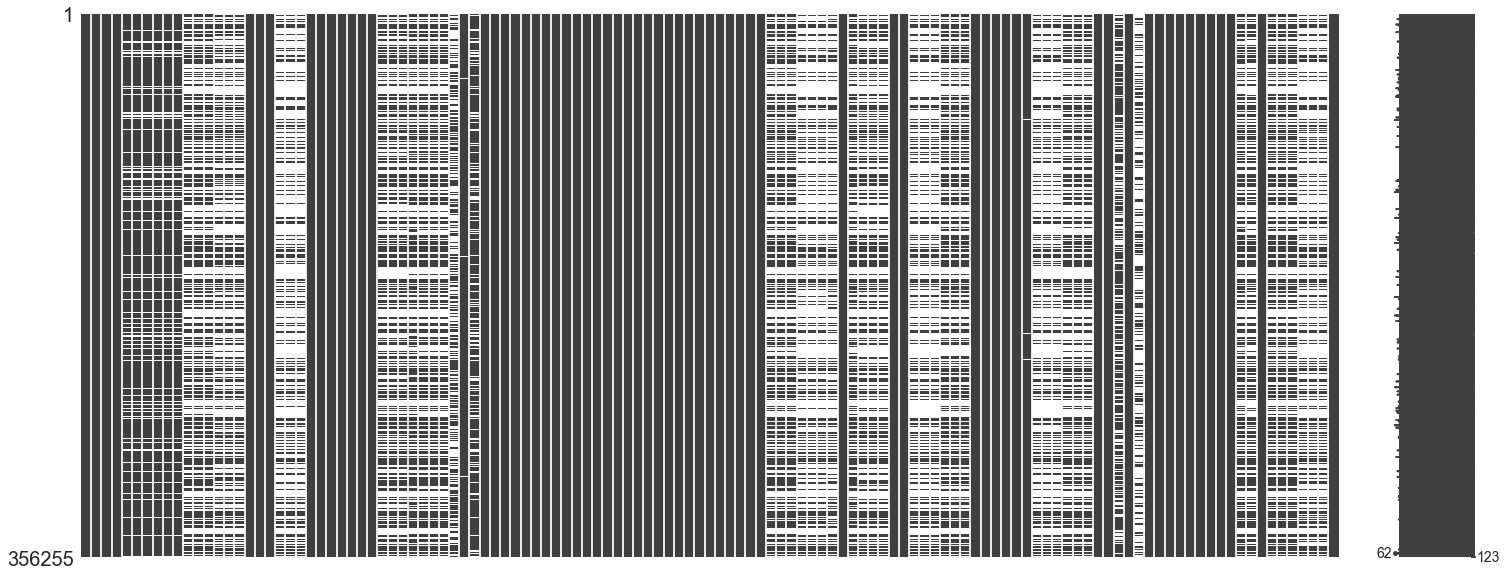

In [12]:
print(len(df_process))
msno.matrix(df_process)

###### [Overview "TARGET" in train data]

In [13]:
# amount of data
df_train['TARGET'].count()

307511

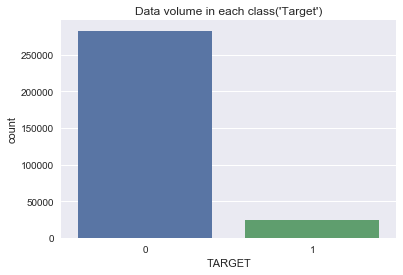

Rate of rated=8.78[%]


In [14]:
# plot TARGET 
sns.countplot(x="TARGET", data=df_train)
plt.title("Data volume in each class('Target')")
plt.show()
tmp = df_train["TARGET"]
count_1 = (tmp==1).sum()
count_0 = (tmp==0).sum()
print("Rate of rated={:.2f}[%]".format((count_1/count_0)*100))

When lending money to 307511 people,
24825 people who do not return money.
282686people who will return the money.


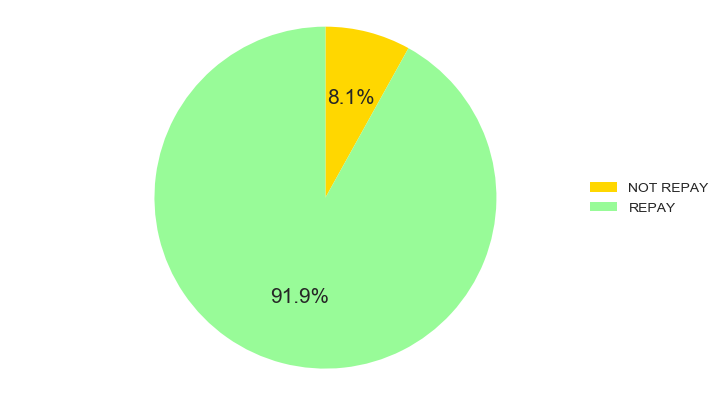

In [15]:
# TRUE: NOT REPAY, FALSE:REPAY
TARGET_TRUE = df_train["TARGET"].sum() 
TARGET_FALSE = df_train["TARGET"].count() - df_train["TARGET"].sum() 

list_TARGET = [TARGET_TRUE, TARGET_FALSE]

print("When lending money to {} people,".format(TARGET_TRUE+TARGET_FALSE))
print("{} people who do not return money.".format(TARGET_TRUE))
print("{}people who will return the money.".format(TARGET_FALSE))


# draw the pie
label = ['NOT REPAY', 'REPAY']
colors = ['gold', 'palegreen']
size = [15, 30, 45]
explode = (0, 0.1, 0)

plt.style.use('ggplot')
plt.rcParams.update({'font.size':15})

size=(9,5)

plt.figure(figsize=size,dpi=100)
plt.pie(list_TARGET,colors=colors,counterclock=False,startangle=90,autopct=lambda p:'{:.1f}%'.format(p) if p>=5 else '')
plt.subplots_adjust(left=0,right=0.7)
plt.legend(label,fancybox=True,loc='center left',bbox_to_anchor=(0.9,0.5))
plt.axis('equal') 
plt.savefig('figure.png',bbox_inches='tight',pad_inches=0.05)

##### It is biased data

### 3.1 Add new feature(the number of missing value)

In [16]:
df_process['AMOUNT_OF_NaN'] = df_process.isnull().sum(axis=1)

In [17]:
df_process

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,EMERGENCYSTATE_MODE,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_EMAIL,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMAX_MODE,FLOORSMIN_AVG,FLOORSMIN_MEDI,FLOORSMIN_MODE,FONDKAPREMONT_MODE,HOUR_APPR_PROCESS_START,HOUSETYPE_MODE,LANDAREA_AVG,LANDAREA_MEDI,LANDAREA_MODE,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,NAME_TYPE_SUITE,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_AVG,NONLIVINGAREA_MEDI,NONLIVINGAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE,ORGANIZATION_TYPE,OWN_CAR_AGE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,SK_ID_CURR,TARGET,TOTALAREA_MODE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE,train_test,AMOUNT_OF_NaN
0,24700.5,406597.5,351000.0,202500.000,0.0,0.0,0.0,0.0,0.0,1.0,0.0247,0.0250,0.0252,0.0369,0.0369,0.0383,0,1.0,M,0.0143,0.0144,0.0144,-9461,-637,-2120,-1134.0,-3648.0,2.0,2.0,0.0000,0.00,0.0000,No,0.0690,0.0690,0.0690,0.083037,0.262949,0.139376,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,N,Y,1,0,0.0833,0.0833,0.0833,0.1250,0.1250,0.1250,reg oper account,10,block of flats,0.0369,0.0375,0.0377,0,0,0.0202,0.0205,0.0220,0.0190,0.0193,0.0198,Cash loans,Secondary / secondary special,Single / not married,House / apartment,Working,Unaccompanied,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0,2.0,Laborers,Business Entity Type 3,NaN,0.018801,2,2,0,0,0,0,100002,1,0.0149,"Stone, brick",WEDNESDAY,0.9722,0.9722,0.9722,0.6192,0.6243,0.6341,0,1
1,35698.5,1293502.5,1129500.0,270000.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0959,0.0968,0.0924,0.0529,0.0529,0.0538,0,2.0,F,0.0605,0.0608,0.0497,-16765,-1188,-291,-828.0,-1186.0,0.0,0.0,0.0800,0.08,0.0806,No,0.0345,0.0345,0.0345,0.311267,0.622246,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,N,N,1,0,0.2917,0.2917,0.2917,0.3333,0.3333,0.3333,reg oper account,11,block of flats,0.0130,0.0132,0.0128,0,0,0.0773,0.0787,0.0790,0.0549,0.0558,0.0554,Cash loans,Higher education,Married,House / apartment,State servant,Family,0.0039,0.0039,0.0000,0.0098,0.0100,0.0000,1.0,1.0,Core staff,School,NaN,0.003541,1,1,0,0,0,0,100003,0,0.0714,Block,MONDAY,0.9851,0.9851,0.9851,0.7960,0.7987,0.8040,0,2
2,6750.0,135000.0,135000.0,67500.000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,M,NaN,NaN,NaN,-19046,-225,-2531,-815.0,-4260.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.555912,0.729567,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,Y,Y,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Revolving loans,Secon

### 4. Delete missing value 

In [18]:
process_object_list = df_process.select_dtypes(include=['object']).columns
df_process_object = pd.DataFrame([process_object_list]).T

for col in process_object_list:
    print(df_process[col].value_counts())
    print('--------------------------------')

# df_train_object.to_csv("output_df_train_object.csv", encoding="shift_jis")

F      235126
M      121125
XNA         4
Name: CODE_GENDER, dtype: int64
--------------------------------
No     185607
Yes      2684
Name: EMERGENCYSTATE_MODE, dtype: int64
--------------------------------
N    235235
Y    121020
Name: FLAG_OWN_CAR, dtype: int64
--------------------------------
Y    246970
N    109285
Name: FLAG_OWN_REALTY, dtype: int64
--------------------------------
reg oper account         85954
reg oper spec account    14070
not specified             6600
org spec account          6539
Name: FONDKAPREMONT_MODE, dtype: int64
--------------------------------
block of flats      175162
specific housing      1761
terraced house        1416
Name: HOUSETYPE_MODE, dtype: int64
--------------------------------
Cash loans         326537
Revolving loans     29718
Name: NAME_CONTRACT_TYPE, dtype: int64
--------------------------------
Secondary / secondary special    252379
Higher education                  87379
Incomplete higher                 12001
Lower secondary     

In [19]:
df_process = df_process.dropna(thresh=1, axis=1)

In [20]:
df_process.shape

(356255, 124)

In [21]:
# check the null
df_nan = pd.DataFrame(df_process.isnull().sum())
df_nan = df_nan.rename(index=str, columns={0:'Null_Num'})
df_nan.sort_values(by=['Null_Num'], ascending=False)
# df_nan.to_csv("output_null_list.csv", encoding="shift_jis")

,Null_Num
COMMONAREA_MODE,248360
COMMONAREA_MEDI,248360
COMMONAREA_AVG,248360
NONLIVINGAPARTMENTS_AVG,246861
NONLIVINGAPARTMENTS_MEDI,246861
NONLIVINGAPARTMENTS_MODE,246861
FONDKAPREMONT_MODE,243092
LIVINGAPARTMENTS_AVG,242979
LIVINGAPARTMENTS_MODE,242979
LIVINGAPARTMENTS_MEDI,242979


### 4. Fill missiong values

356255


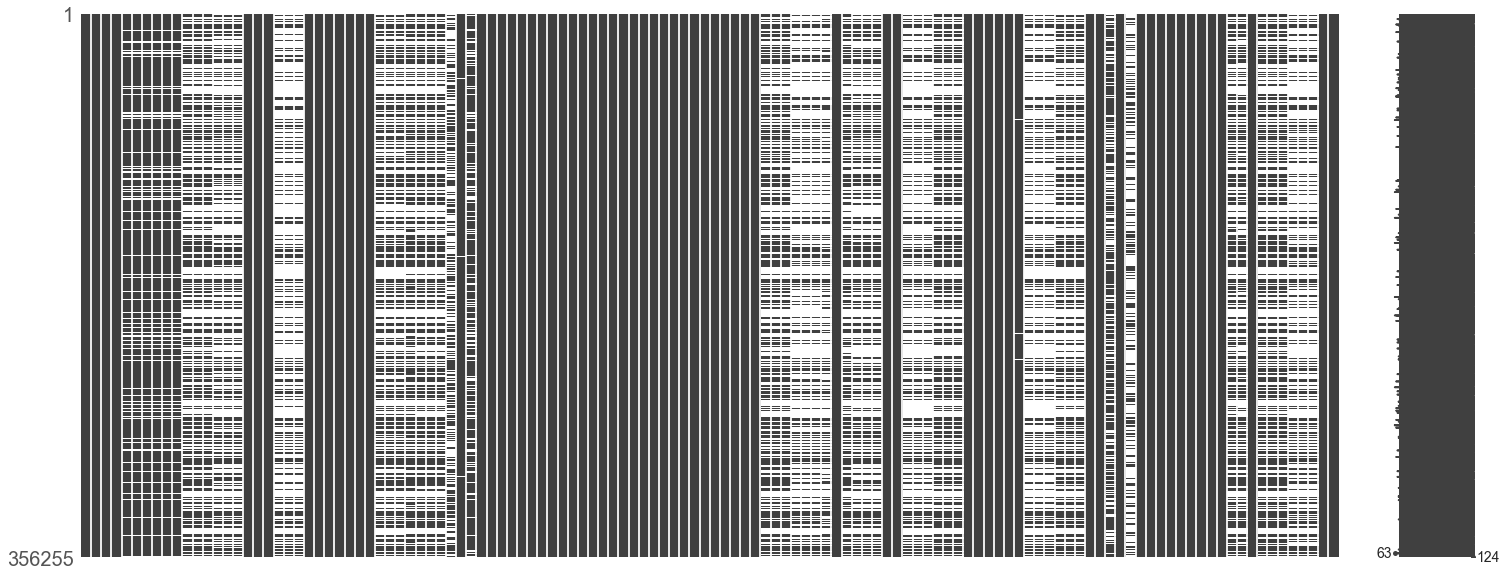

In [22]:
print(len(df_process))
msno.matrix(df_process)

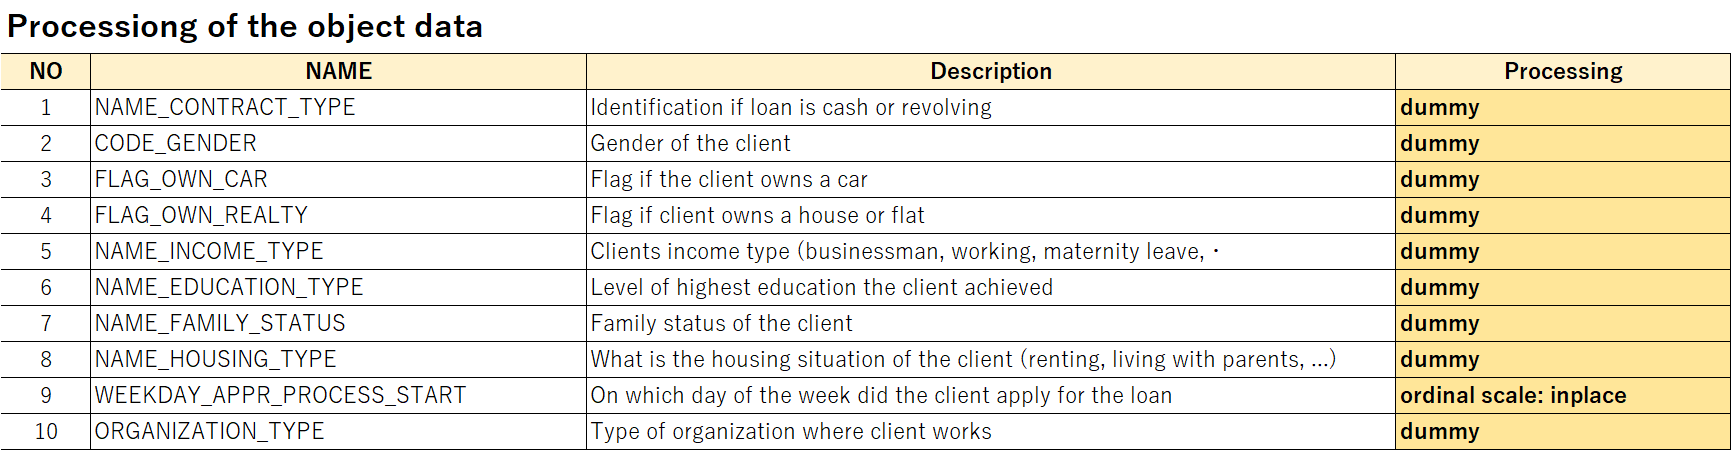

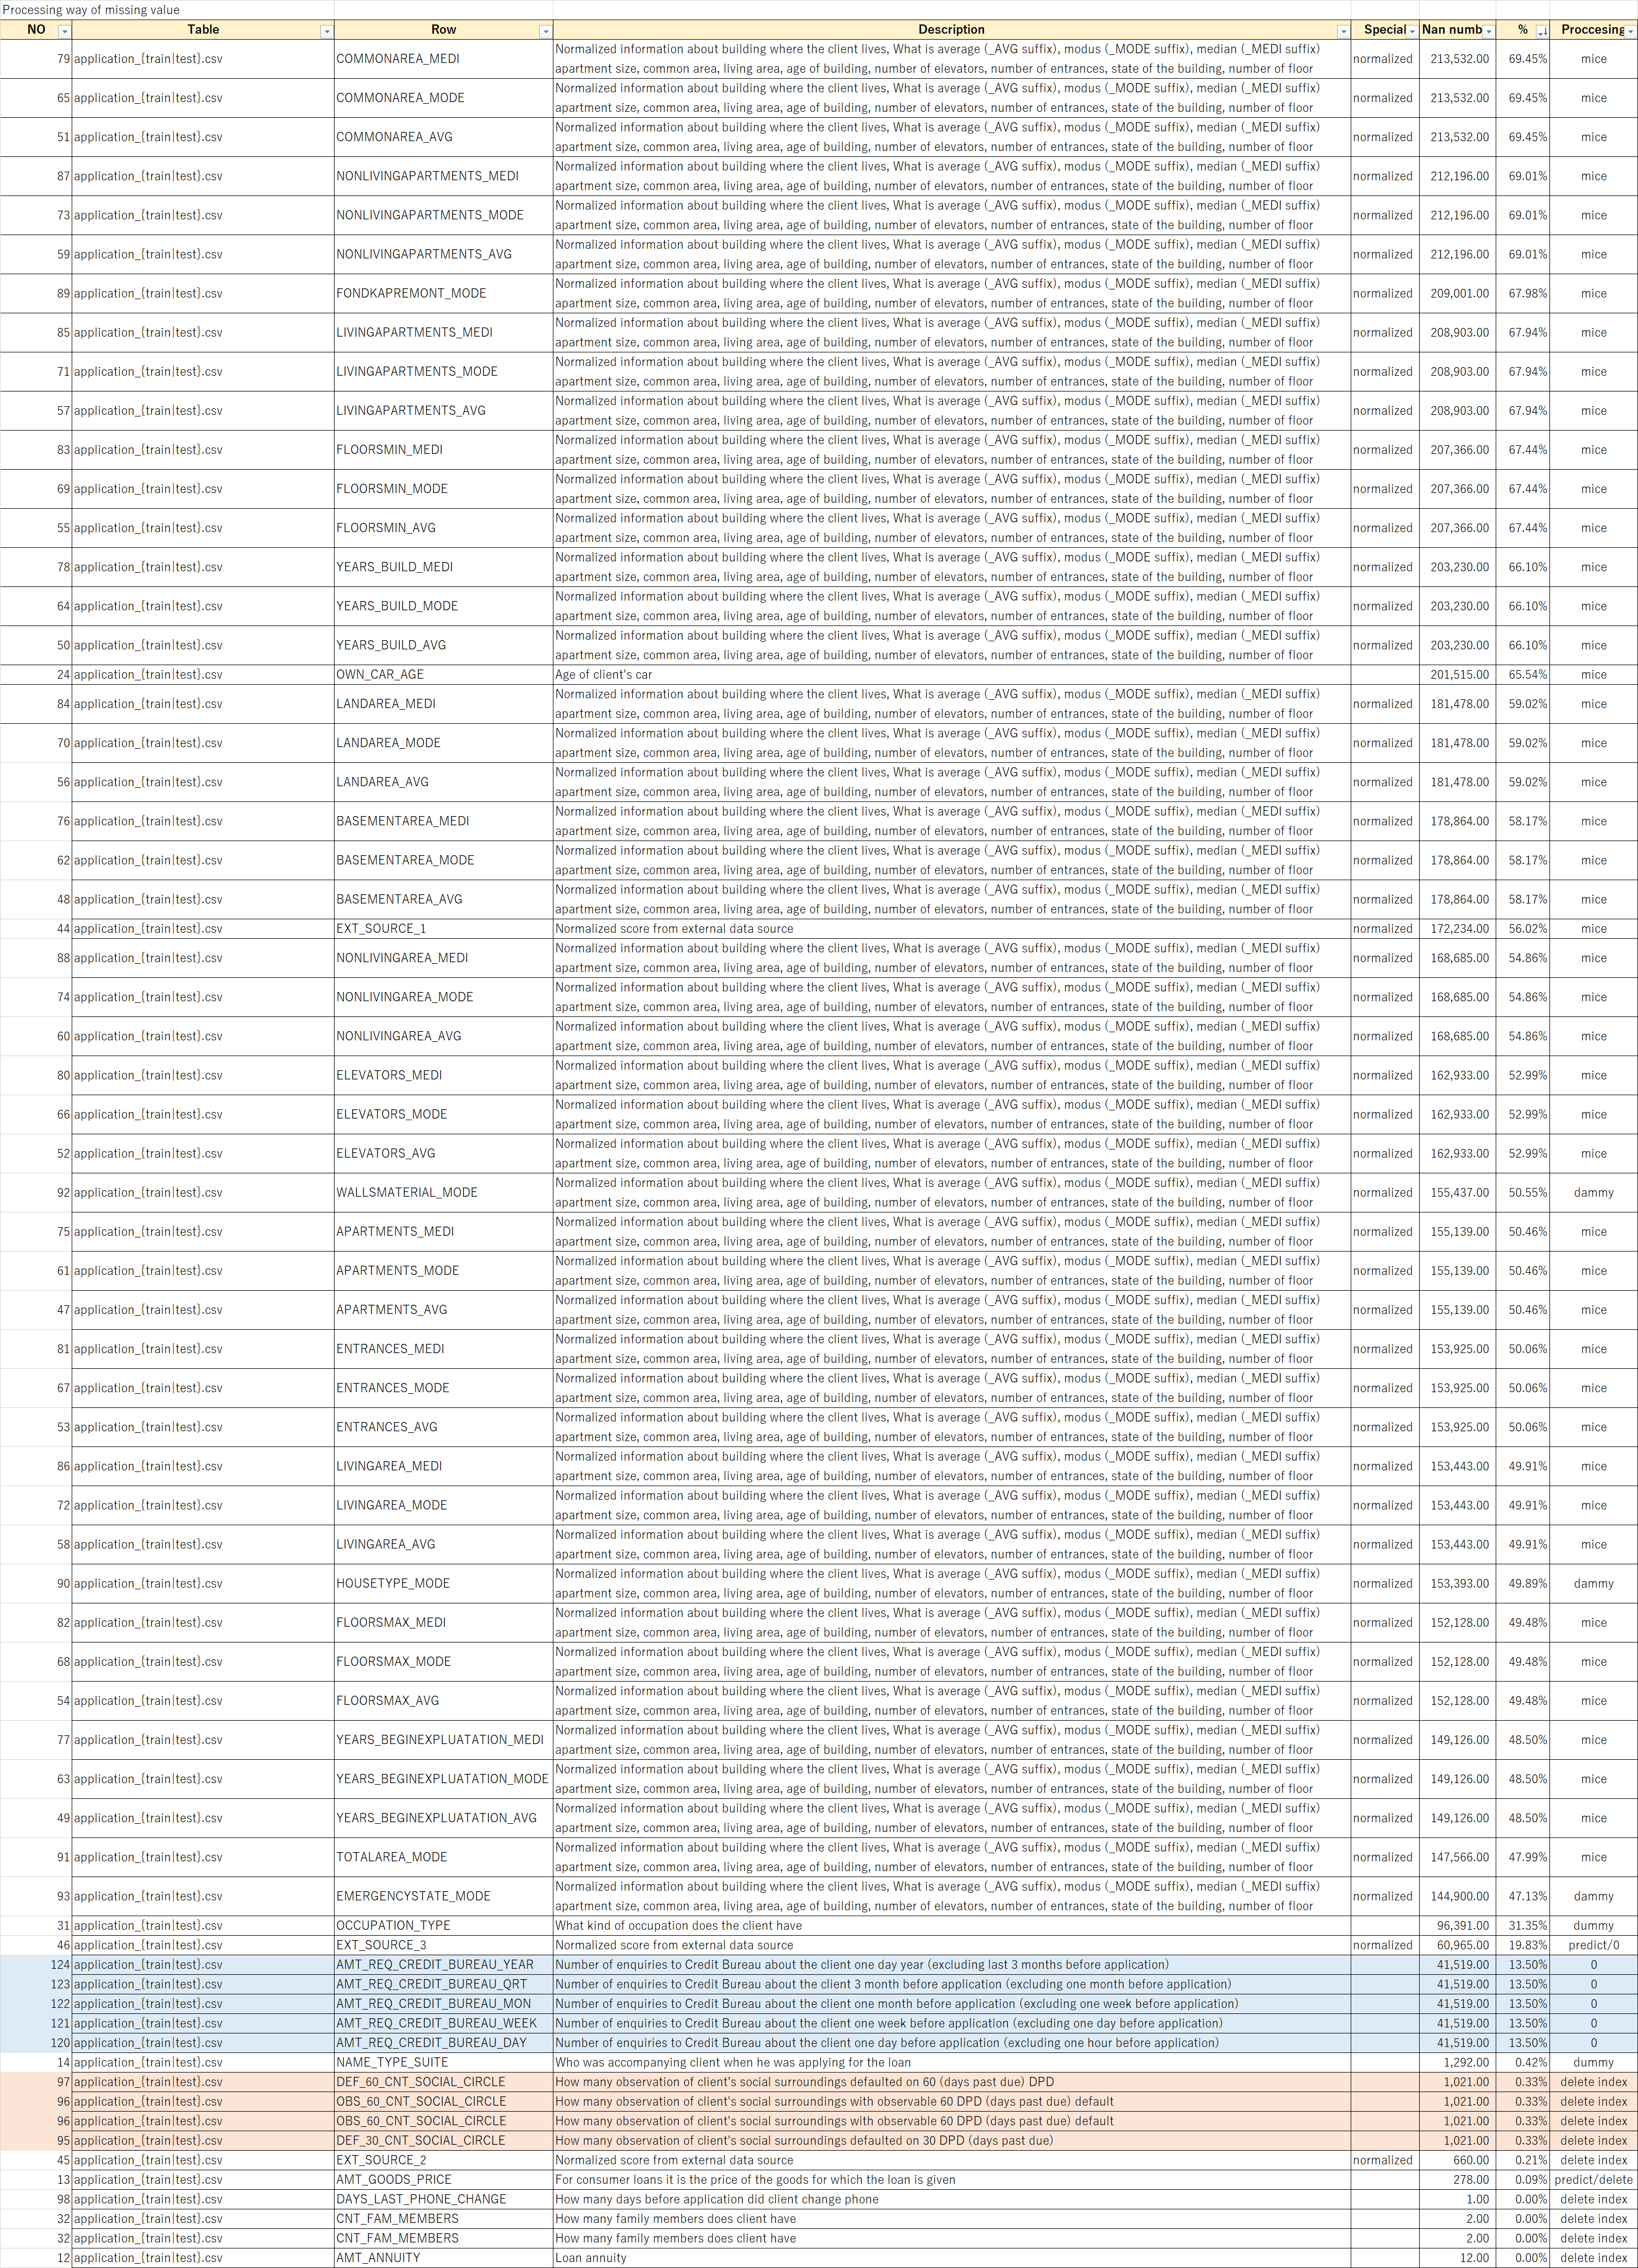

In [23]:
# plan
import os
import os.path
from IPython.display import display
from PIL import Image

path1 = "object.png"
display(Image.open(path1))


path = "nan.png"
display(Image.open(path))

#### 'OCCUPATION_TYPE' 

In [24]:
df_process['OCCUPATION_TYPE'].value_counts()

Laborers                 63841
Sales staff              37174
Core staff               31931
Managers                 24945
Drivers                  21376
High skill tech staff    13234
Accountants              11441
Medicine staff            9853
Security staff            7636
Cooking staff             6840
Cleaning staff            5309
Private service staff     3107
Low-skill Laborers        2365
Waiters/barmen staff      1526
Secretaries               1518
Realty agents              889
HR staff                   667
IT staff                   607
Name: OCCUPATION_TYPE, dtype: int64

##### There is not Unemployed in 'OCCUPATION_TYPE'.
So We regard missing values in 'OCCUPATION_TYPE' as  people unemployed and not to answer the questions.

#### EXT_SOURCE_3

In [25]:
# df_train_sample['EXT_SOURCE_3'] # Linear Regression

In [26]:
# genarate each ways of processing

# list to delete indexs in each columns
delete_index_nan_list =['DEF_30_CNT_SOCIAL_CIRCLE',
                  'OBS_60_CNT_SOCIAL_CIRCLE',
                  'DEF_60_CNT_SOCIAL_CIRCLE',
                  'OBS_60_CNT_SOCIAL_CIRCLE',
                  'EXT_SOURCE_2',
                  'AMT_GOODS_PRICE',
                  'AMT_ANNUITY',
                  'CNT_FAM_MEMBERS',
                  'CNT_FAM_MEMBERS',
                  'DAYS_LAST_PHONE_CHANGE']

# list to replace to zero columns
replace_nan_zero_list =['AMT_REQ_CREDIT_BUREAU_HOUR',
                        'AMT_REQ_CREDIT_BUREAU_DAY',
                        'AMT_REQ_CREDIT_BUREAU_WEEK',
                        'AMT_REQ_CREDIT_BUREAU_MON',
                        'AMT_REQ_CREDIT_BUREAU_QRT',
                        'AMT_REQ_CREDIT_BUREAU_YEAR',
                        'EXT_SOURCE_3']

# list to replace object data to int data
replace_object_list =['WEEKDAY_APPR_PROCESS_START']

# other object data change to dummy data

# list to replace NaN to regression score from other value
continuous_list = ['COMMONAREA_AVG',
                    'COMMONAREA_MODE',
                    'COMMONAREA_MEDI',
                    'NONLIVINGAPARTMENTS_AVG',
                    'NONLIVINGAPARTMENTS_MODE',
                    'NONLIVINGAPARTMENTS_MEDI',
                    'LIVINGAPARTMENTS_AVG',
                    'LIVINGAPARTMENTS_MODE',
                    'LIVINGAPARTMENTS_MEDI',
                    'FLOORSMIN_AVG',
                    'FLOORSMIN_MODE',
                    'FLOORSMIN_MEDI',
                    'YEARS_BUILD_AVG',
                    'YEARS_BUILD_MODE',
                    'YEARS_BUILD_MEDI',
                    'OWN_CAR_AGE',
                    'LANDAREA_AVG',
                    'LANDAREA_MODE',
                    'LANDAREA_MEDI',
                    'BASEMENTAREA_AVG',
                    'BASEMENTAREA_MODE',
                    'BASEMENTAREA_MEDI',
                    'EXT_SOURCE_1',
                    'NONLIVINGAREA_AVG',
                    'NONLIVINGAREA_MODE',
                    'NONLIVINGAREA_MEDI',
                    'ELEVATORS_AVG',
                    'ELEVATORS_MODE',
                    'ELEVATORS_MEDI',
                    'APARTMENTS_AVG',
                    'APARTMENTS_MODE',
                    'APARTMENTS_MEDI',
                    'ENTRANCES_AVG',
                    'ENTRANCES_MODE',
                    'ENTRANCES_MEDI',
                    'LIVINGAREA_AVG',
                    'LIVINGAREA_MODE',
                    'LIVINGAREA_MEDI',
                    'FLOORSMAX_AVG',
                    'FLOORSMAX_MODE',
                    'FLOORSMAX_MEDI',
                    'YEARS_BEGINEXPLUATATION_AVG',
                    'YEARS_BEGINEXPLUATATION_MODE',
                    'YEARS_BEGINEXPLUATATION_MEDI',
                    'TOTALAREA_MODE']

In [27]:
'''

Processing about object values

'''
# delete 
df_process.dropna(subset=delete_index_nan_list, inplace=True)

# inplace zero
for column in replace_nan_zero_list:
    df_process[column].fillna(0, inplace=True)
    
    
# replace object to int type
for column in replace_object_list:
    df_process[column], _ = pd.factorize(df_process[column])
    df_process[column] = df_process[column].astype('int')
    
    
process_object_list = df_process.select_dtypes(include=['object']).columns

# dummy
df_process_add = pd.get_dummies(df_process[process_object_list], dummy_na=True) # generate dummy dataframe
df_process_done = pd.concat([df_process, df_process_add], axis=1) # marge dummy dataframe
df_process_done.drop(process_object_list, axis=1, inplace=True) # delete columns of the previous dummy data

df_process_done.select_dtypes(include=['object']).columns
df_process_done.shape

(354228, 256)

In [28]:
'''
Awesome:
Processing about continuous values

'''

import sklearn.linear_model as lm

reg = lm.LinearRegression()

for column in continuous_list:
    indexer = df_process_done[column].isnull()
    X_columns = df_process_done.drop(continuous_list, axis=1).columns
    
    reg.fit(df_process_done.loc[~indexer, X_columns], df_process_done.loc[~indexer, column])
    predicted = reg.predict(df_process_done.loc[indexer, X_columns])
    df_process_done.loc[indexer, column] = predicted

In [29]:
# check the null
df_pro = pd.DataFrame(df_process_done.isnull().sum())
df_pro = df_pro.rename(index=str, columns={0:'Null_Num'})
df_pro.sort_values(by=['Null_Num'], ascending=False)
# df_pro.to_csv("output_null_list1.csv", encoding="shift_jis")

,Null_Num
AMT_ANNUITY,0
AMT_CREDIT,0
NAME_TYPE_SUITE_Children,0
NAME_TYPE_SUITE_Family,0
NAME_TYPE_SUITE_Group of people,0
NAME_TYPE_SUITE_Other_A,0
NAME_TYPE_SUITE_Other_B,0
"NAME_TYPE_SUITE_Spouse, partner",0
NAME_TYPE_SUITE_Unaccompanied,0
NAME_TYPE_SUITE_nan,0


In [30]:
# devide train and test data
df_train = df_process_done[df_process_done['train_test'] == 0]
df_train = df_train.drop(['train_test'], axis=1)

df_test = df_process_done[df_process_done['train_test'] == 1]
df_test = df_test.drop(['train_test', 'TARGET'], axis=1)

### 6. Ramdom sampling

In [31]:
# Random sampling 40000 index
import random
df_train = df_train.sample(n=40000, random_state=1) # random sead
df_train.head() 

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,CNT_CHILDREN,CNT_FAM_MEMBERS,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_EMAIL,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_PHONE,FLAG_WORK_PHONE,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMAX_MODE,FLOORSMIN_AVG,FLOORSMIN_MEDI,FLOORSMIN_MODE,HOUR_APPR_PROCESS_START,LANDAREA_AVG,LANDAREA_MEDI,LANDAREA_MODE,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_AVG,NONLIVINGAREA_MEDI,NONLIVINGAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OWN_CAR_AGE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,SK_ID_CURR,TARGET,TOTALAREA_MODE,WEEKDAY_APPR_PROCESS_START,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE,AMOUNT_OF_NaN,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,CODE_GENDER_nan,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_CAR_nan,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,FLAG_OWN_REALTY_nan,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,FONDKAPREMONT_MODE_nan,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,HOUSETYPE_MODE_nan,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_nan,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_EDUCATION_TYPE_nan,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_nan,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_nan,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_nan,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine st

元データ数：40000　学習データ数：30000　検証データ数：10000


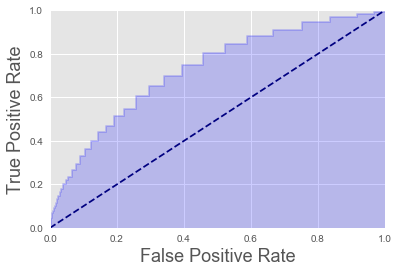

AUC=0.74228


In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=120, random_state=40)
result, fpr, tpr, thresholds = pipline(clf, df_train, "TARGET", df_test.columns, 1, False)

print("AUC={:.5f}".format(metrics.auc(fpr, tpr)))

### 10. Submission